# Grounded Segment Anything -- (Light-HQSAM)

Automatically detect and retrieve a mask for *any* object in a picture.

Just press play button on the setup cell, then select `Runtime` -> `Restart session` from toolbar and press play on the remaining cells.

In [ ]:
# @title Set up (takes ~2min, be patient)
! git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git
%cd Grounded-Segment-Anything
! python -m pip install --no-cache-dir -e segment_anything
! python -m pip install --no-cache-dir wheel
! python -m pip install --no-cache-dir --no-build-isolation -e GroundingDINO
! pip install --no-cache-dir diffusers[torch]==0.15.1 opencv-python==4.7.0.72 \
    pycocotools==2.0.6 matplotlib==3.5.3 \
    onnxruntime==1.14.1 onnx==1.13.1 ipykernel==6.16.2 scipy gradio openai

! wget -O groundingdino_swint_ogc.pth https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth?download=true
! wget -O EfficientSAM/sam_hq_vit_tiny.pth https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_tiny.pth?download=true

# Restart Runtime!
Once the above finishes loading, go to `Runtime` -> `Restart session` in the toolbar. Then press the play button below...

In [1]:
# @title Load Models

%cd /content/Grounded-Segment-Anything/EfficientSAM/
import cv2
from PIL import Image
import numpy as np
import supervision as sv

import torch
import torchvision

from diffusers.utils import load_image

from groundingdino.util.inference import Model
from segment_anything import SamPredictor
from LightHQSAM.setup_light_hqsam import setup_model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GroundingDINO config and checkpoint
GROUNDING_DINO_CONFIG_PATH = "../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "../groundingdino_swint_ogc.pth"

# Building GroundingDINO inference model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

# Building MobileSAM predictor
HQSAM_CHECKPOINT_PATH = "sam_hq_vit_tiny.pth"
checkpoint = torch.load(HQSAM_CHECKPOINT_PATH)
light_hqsam = setup_model()
light_hqsam.load_state_dict(checkpoint, strict=True)
light_hqsam.to(device=DEVICE)

sam_predictor = SamPredictor(light_hqsam)

# Predict classes and hyper-param for GroundingDINO
SOURCE_IMAGE_PATH = "LightHQSAM/example_light_hqsam.png"
#CLASSES = ["bench"]
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8



# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False,
            hq_token_only=True,
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)


def mask_image(url, query):
    """Retrieve a mask and masked image based on a object query."""

    # can send a list of classes or comma separated string
    if isinstance(query, str):
      query = [s for s in query.split(',')]
    CLASSES = query # for compatibility

    # load image & move to cv2
    pil_image = load_image(url)
    image = np.array(pil_image)
    # Convert RGB to BGR
    image = image[:, :, ::-1].copy()

    # detect objects
    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=query,
        box_threshold=BOX_THRESHOLD,
        text_threshold=BOX_THRESHOLD
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _ , _
        in detections]
    annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    # NMS post process
    nms_idx = torchvision.ops.nms(
        torch.from_numpy(detections.xyxy),
        torch.from_numpy(detections.confidence),
        NMS_THRESHOLD
    ).numpy().tolist()

    detections.xyxy = detections.xyxy[nms_idx]
    detections.confidence = detections.confidence[nms_idx]
    detections.class_id = detections.class_id[nms_idx]

    # convert detections to masks
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )

    # annotate image with detections
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _, _
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    # get mask
    bw_array = np.uint8(detections.mask.sum(axis=0)) * 255
    mask = Image.fromarray(bw_array, 'L')

    # save the annotated grounded-sam image
    return Image.fromarray(annotated_image[:, :, ::-1]), pil_image, mask



/content/Grounded-Segment-Anything/EfficientSAM


2024-02-19 05:58:20.311114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 05:58:20.311193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 05:58:20.313320: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 05:58:22.292370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/content/Grounded-Segment-Anything/EfficientSAM/LightHQSAM/tiny_vit_sam.py:662: UserWarning: Overwriting tiny_vit_5m_224 in registry with LightHQSAM.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an ex

final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


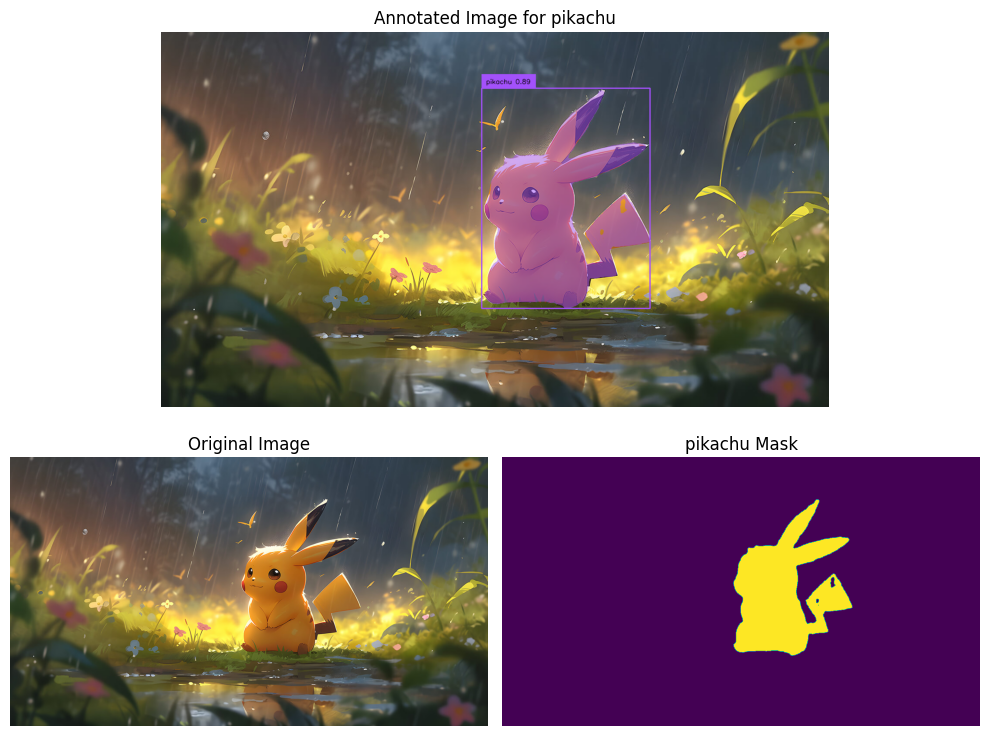

In [3]:
# @title Inference!
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

url = "https://wallpapers-clan.com/wp-content/uploads/2023/11/cute-pokemon-pikachu-rain-desktop-wallpaper-preview.jpg" # @param {type:"string"}
query = "pikachu" # @param {type:"string"}
an, im, mask = mask_image(url, query)

annotated_array = np.array(an)
original_array = np.array(im)
mask_array = np.array(mask)

# Create figure and a gridspec layout
fig = plt.figure(figsize=(10, 8))

# Define grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# Annotated image across the first row, taking up both columns
ax0 = plt.subplot(gs[0, :])
ax0.imshow(annotated_array)
ax0.set_title(f"Annotated Image for {query}")
ax0.axis('off')

# Original image on the second row, first column
ax1 = plt.subplot(gs[1, 0])
ax1.imshow(original_array)
ax1.set_title("Original Image")
ax1.axis('off')

# Mask image on the second row, second column
ax2 = plt.subplot(gs[1, 1])
ax2.imshow(mask_array)
ax2.set_title(f"{query} Mask")
ax2.axis('off')

plt.tight_layout()
plt.show()
